# Iris data set: inference with NN / SVI solution

First, install the required Python packages on the fly on Colab.

Import the required Python packages.

In [5]:
import pyro
import numpy
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import model_selection
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn
import arviz

Set some parameters for inference and make reproducible.



In [6]:
seed_value = 42  # Replace with your desired seed value
torch.manual_seed(seed_value)
pyro.set_rng_seed(seed_value)
numpy.random.seed(seed_value)

# MAP or diagonal normal?
MAP = True
if MAP:
    MAXIT = 2000  # SVI iterations
    REPORT = 200  # Plot ELBO each time after this amount of SVI iterations
else:
    MAXIT = 100000
    REPORT = 1000

# Number of samples used in prediction
S = 500

Function to evaluate the accuracy of our trained model.

In [7]:
def accuracy(pred, data):
    """
    Calculate accuracy of predicted labels (integers).

    pred: predictions, tensor[sample_index, chain_index, data_index, logits]
    data: actual data (digit), tensor[data_index]

    Prediction is taken as most common predicted value.
    Returns accuracy (#correct/#total).
    """
    n = data.shape[0]
    correct = 0
    total = 0
    for i in range(0, n):
        # Get most common prediction value from logits
        pred_i = int(torch.argmax(torch.sum(pred[:, 0, i, :], 0)))
        # Compare prediction with data
        if int(data[i]) == int(pred_i):
            correct += 1.0
        total += 1.0
    # Return fractional accuracy
    return correct / total

Load the [iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set) set from [scikit-learn](https://sklearn.org/).

In [8]:
# Iris data set
Dx = 4  # Input vector dim
Dy = 3  # Number of labels

iris = sklearn.datasets.load_iris()
x_all = torch.tensor(iris.data, dtype=torch.float)  # Input vector (4D)
y_all = torch.tensor(iris.target, dtype=torch.int)  # Label(3 classes)

# Make training and test set
x, x_test, y, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, test_size=0.33, random_state=42
)

print("Data set / test set sizes: %i, %i." % (x.shape[0], x_test.shape[0]))

Data set / test set sizes: 100, 50.


The probabilistic model, implemented as a callable class. We could also simply use a function.


In [9]:
class Model:
    def __init__(self, x_dim=4, y_dim=3, h_dim=5):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim

    def __call__(self, x, y=None):
        """
        We need None for predictive
        """
        x_dim = self.x_dim
        y_dim = self.y_dim
        h_dim = self.h_dim
        # Number of observations
        n = x.shape[0]
        # standard deviation of Normals
        sd = 1  # EXERCISE: 100->1
        # Layer 1
        w1 = pyro.sample("w1", pdist.Normal(0, sd).expand([x_dim, h_dim]).to_event(2))
        b1 = pyro.sample("b1", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 2 # EXERCISE: added layer
        w2 = pyro.sample("w2", pdist.Normal(0, sd).expand([h_dim, h_dim]).to_event(2))
        b2 = pyro.sample("b2", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 3
        w3 = pyro.sample("w3", pdist.Normal(0, sd).expand([h_dim, y_dim]).to_event(2))
        b3 = pyro.sample("b3", pdist.Normal(0, sd).expand([y_dim]).to_event(1))
        # NN
        h1 = torch.tanh((x @ w1) + b1)
        h2 = torch.tanh((h1 @ w2) + b2)  # EXERCISE: added layer
        logits = h2 @ w3 + b3
        # Save deterministc variable (logits) in trace
        pyro.deterministic("logits", logits)
        # Categorical likelihood
        with pyro.plate("labels", n):
            obs = pyro.sample("obs", pdist.Categorical(logits=logits), obs=y)

Make the Model and the Guide objects, and optimize the ELBO.  

In [10]:
# Instantiate the Model object
model = Model()

if MAP:
    # MAP estimate of model parameter (here SVI boild down to simple gradient descent)
    guide = pyro.infer.autoguide.AutoDelta(model)
else:
    # Variational estimate of model parameters using diagonal normal (SVI)
    guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Optimizer
adam = pyro.optim.Adam({"lr": 0.01})
# SVI
svi = pyro.infer.SVI(model, guide, adam, loss=pyro.infer.Trace_ELBO())

# Clear any previously used parameters
pyro.clear_param_store()

# Optimize the ELBO
elbo = []
for j in range(0, MAXIT):
    loss = svi.step(x, y)
    elbo.append(loss)
    if j % REPORT == 0:
        print("[Iteration %04d] loss: %.4f" % (j, loss))


[Iteration 0000] loss: 188.0556
[Iteration 0200] loss: 88.5218
[Iteration 0400] loss: 87.6917
[Iteration 0600] loss: 87.5620
[Iteration 0800] loss: 87.5438
[Iteration 1000] loss: 87.5415
[Iteration 1200] loss: 87.5412
[Iteration 1400] loss: 87.5410
[Iteration 1600] loss: 87.5411
[Iteration 1800] loss: 87.5501


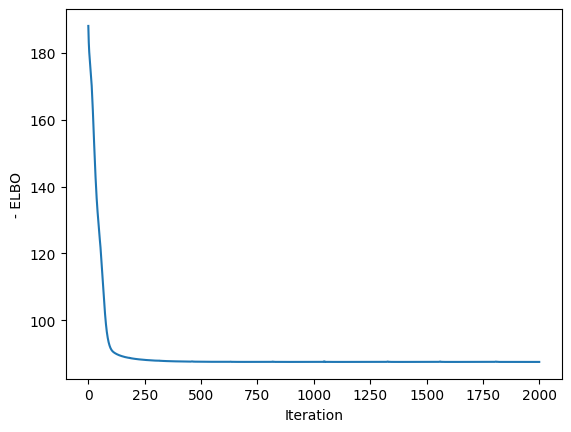

In [11]:
# ELBO vs. iteration plot
plt.xlabel("Iteration")
plt.ylabel("- ELBO")
plt.plot(elbo)

Print the estimated parameters.

In [12]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDelta.w1 Parameter containing:
tensor([[-0.2763,  0.2768,  0.1315, -0.0905, -0.0906],
        [-0.5051,  0.5060,  0.2953, -0.3772, -0.3774],
        [ 0.5029, -0.5037, -0.3144,  0.6118,  0.6120],
        [ 0.8445, -0.8458, -0.4532,  0.2644,  0.2644]], requires_grad=True)
AutoDelta.b1 Parameter containing:
tensor([-0.6339,  0.6350,  0.2959, -0.0600, -0.0600], requires_grad=True)
AutoDelta.w2 Parameter containing:
tensor([[ 0.1396,  0.8130, -0.1392, -0.8126,  0.8131],
        [-0.1390, -0.8142,  0.1387,  0.8140, -0.8143],
        [-0.3348, -0.4405,  0.3372,  0.4395, -0.4399],
        [ 0.7147, -0.0385, -0.7145,  0.0384, -0.0385],
        [ 0.7153, -0.0386, -0.7147,  0.0385, -0.0386]], requires_grad=True)
AutoDelta.b2 Parameter containing:
tensor([ 0.1219, -0.1284, -0.1222,  0.1283, -0.1284], requires_grad=True)
AutoDelta.w3 Parameter containing:
tensor([[-1.3203,  0.9797,  0.3405],
        [-0.4262, -0.7263,  1.1525],
        [ 1.3203, -0.9798, -0.3406],
        [ 0.4264,  0.7256, -1

Get the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) by sampling the model's parameters from the Guide object and applying the model to the test set.

In [13]:
guide.requires_grad_(False)

posterior_predictive = pyro.infer.Predictive(
    model, guide=guide, num_samples=S, return_sites=["logits"]
)(x_test, None)

Evaluate the accuracy of the model on the test set.


In [14]:
# Print accuracy
logits = posterior_predictive["logits"]
print("Shape of posterior preditive for y (logits):", logits.shape)
print("Success: %.2f" % accuracy(logits, y_test))

Shape of posterior preditive for y (logits): torch.Size([500, 1, 50, 3])
Success: 0.98
